# Lecture 7: Image Analysis with Python

Because this is a long notebook, here is a table of content that you can click and jump to each part:

Part 0. [install and import modules](#download)

Part 1. [using Napari to visualize and interact with images](#Napari)

Part 2. [image processing and filters](#process)

Part 3. [feature extraction](#feature)

Part 4. [Analysis pipeline on a toy example](#example)


---

###  <font color='orange'> Part 0: install and import modules </font>  <a id= download></a>

In [47]:
# installation: 

!pip install scikit-image
!pip install napari 
!pip install scipy
!pip install ipywidgets

In [48]:
# Main modules to use: 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import napari # image viewer
from skimage import data # iamge database
from skimage.io import imread # image reader 
import scipy.ndimage as ndi # multidimensional image processing
from skimage import morphology # morphological operation

%matplotlib inline

----

### <font color='orange'>  Part 1: using Napari to visualize and interact with images </font>  <a id= Napari></a>

[Napari](https://napari.org/) is a fast, interactive, multi-dimensional image viewer in Python.

We will open a napari viewer from here, add images and perform some interactions with them.



In [49]:
# a micrograph example from skimage:

viewer = napari.view_image(data.cells3d(), channel_axis=1, ndisplay=3)
napari.run()  # start the "event loop" and show the viewer

Napari can be opened in one of multiple ways, depending on how it’s used in your image analysis workflow. Here are another way:

- From command line: `$ napari`

- To run the same commands as the code above, open napari IPython console, and type:

``` python
# copy this: 
from skimage import data
viewer.add_image(data.cells3d()), channel_axis=1, ndisplay=3)
```

- You can of course, code all your instrcutions, but can also directly interact with the GUI

In [124]:
# launch a viewer and add a gray scale image:
viewer = napari.Viewer()
image_human_mitosis = data.human_mitosis()
viewer.add_image(image_human_mitosis, name = 'mitosis')

<Image layer 'mitosis' at 0x7fcd520ed850>

In [126]:
# image dimension: 
image_human_mitosis.shape

(512, 512)

In [127]:
# retrieve display elements: (follow a hierarchy)
current_colormap = viewer.layers[0].colormap.name
current_colormap

'gray'

In [128]:
# change dispaly elements:
viewer.layers[0].colormap = 'magma' 
viewer.layers[0].opacity = .8

We can annotate the image by adding layers: (go to the GUI)

In [129]:
viewer.layers

[<Image layer 'mitosis' at 0x7fcd520ed850>]

In [131]:
# change elements by names:
viewer.layers['Points'].face_color = 'yellow'

We can also manually label a cell: (go to the GUI), and get different measurements, e.g., cell area:

``` python
# copy this 
from skimage.measure import regionprops
props = regionprops(viewer.layers['Labels'].data)
print("the cell area is: ", props[0].area)
```

-----

### <font color='orange'> Part 2: image processing and filters </font>  <a id= process></a>

What we do with `Napari` are mostly visualization: it changes how you look at an image, and it might help us see some features more easily.

What is an image exactly? 

- an image is just a matrix of numbers

- pixel: "picture element"

- the "edges" between pixels are an artifact: they are a just a visual effect created by sharp change in gradient of pixel intesnities, so ... they don't really exist!

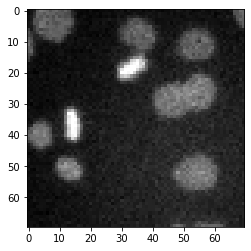

In [132]:
image_path = 'mitosis_mod.tif'
mitosis_img = imread(image_path)
plt.imshow(mitosis_img, cmap = 'gray')

In `skimage`, images are simply numpy arrays, so you can view part of the image by slicing it:

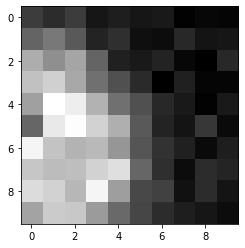

In [133]:
plt.imshow(mitosis_img[5:15, 55:65], cmap = 'gray')

Some potentially confusing concepts of images:

#### __pixel size v.s. resolution__: 

    - __pixel size__ is a digital property of an image (dpi, ppi), you configure it during the imaging session when you do the micrsocopy;

    - __resolution__ is a property of your imaging system. Spatial resolution measures how close object can be in an image while being differentiable

<br/>

#### __bit-depth__:

    - the bit-depth *n* enuerates how many different intesnity values are present in an image: $2^n$ gray values
    
    - in microsopy, images are usually stored as 8, 12, or 16 bit images.


In [134]:
# check the image bit depth:
print("Mitosis image is of type:", mitosis_img.dtype)

Mitosis image is of type: uint8


#### __color maps/lookup tables__:

    - The lookup table decides how the image is displayed on screen
    - it doesn't change the image! All pixel values stays the same, they just appear differently 

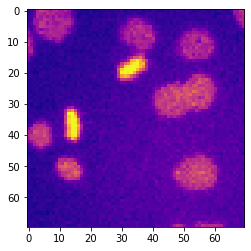

In [135]:
plt.imshow(mitosis_img, cmap = 'plasma')

####  __image histogram__:

<BarContainer object of 248 artists>

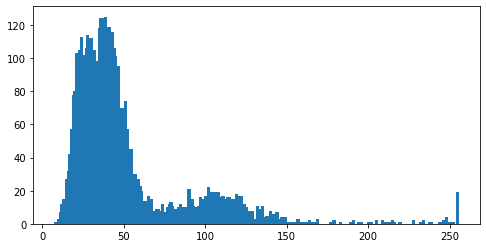

In [136]:
from skimage.exposure import histogram

# create an empty figure with a specific screen size 
plt.figure(figsize=(8,4))
# calculate the image histogram
pixel_counts, pixel_values = histogram(mitosis_img) 
# plot the histogram
plt.bar(pixel_values, pixel_counts, width=2) 

The first big group to the left corresponds to small value pixels, which in this case is the background. There is a second cluster at between 70 and 150, which corresponds to the cells (foreground), because they are brighter than the background.

Then there are small peak at the very end, more specifically, at 255. This is evidence that we have saturated pixels in the image, most likely corresponding to the dividing cells.

#### __brightness and contrast__:

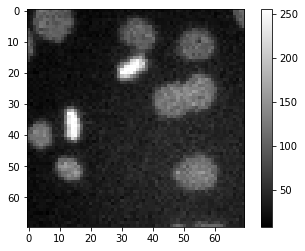

In [137]:
plt.imshow(mitosis_img, cmap='gray')
plt.colorbar()

In [138]:
min_value = mitosis_img.min()
max_value = mitosis_img.max()
print('min value = ', min_value)
print('max value = ', max_value)

min value =  8
max value =  255


Shift the brightness appearance of the image:

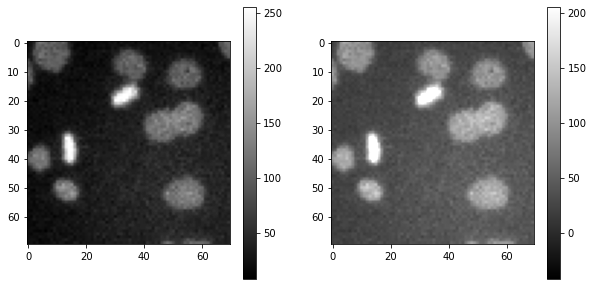

In [139]:
# creates a figure with 2 axes for plotting
fig, ax = plt.subplots(1,2, figsize=(10,5)) 

image_0 = ax[0].imshow(mitosis_img, cmap='gray', vmin = min_value, vmax = max_value) 
plt.colorbar(image_0, ax=ax[0]) # adds a colorbar to the image in the first axis

image_1 = ax[1].imshow(mitosis_img, cmap='gray', vmin = min_value - 50, vmax = max_value - 50)
plt.colorbar(image_1, ax=ax[1]) # adds a colorbar to the image in the second axis

Enhance the dispace contrast:

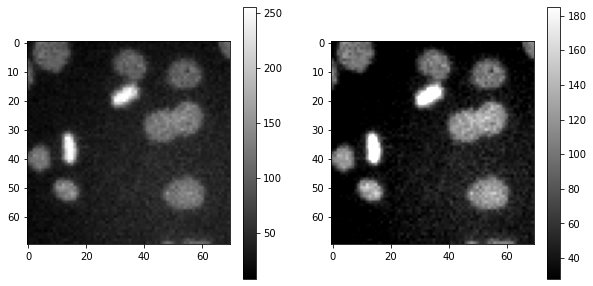

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10,5)) 

axes_image0 = ax[0].imshow(mitosis_img, cmap='gray', vmin = min_value, vmax = max_value) 
plt.colorbar(axes_image0, ax=ax[0]) 
axes_image1 = ax[1].imshow(mitosis_img, cmap='gray', vmin = min_value + 20, vmax = max_value - 70) 
plt.colorbar(axes_image1, ax=ax[1]) 

What we have talked about were still visualizations. Now we move on to discuss processing the image to extract features.

- "where are my cells?" "how we describe their morporlogy?"

First we need to shall distinguish foreground (cells) from the background. Let's see if we can do that easily.

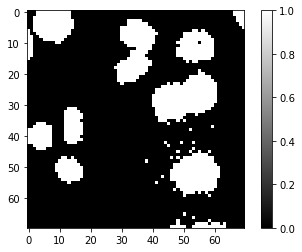

In [66]:
image_binary = mitosis_img > 125
#image_binary = mitosis_img > 60

plt.imshow(image_binary, cmap='gray')
plt.colorbar()

However, manually setting the threshold may only be interesting while exploring the data, not as part of an image analysis workflow.

A few reasons why:

- We do not want to choose this every time by hand;

- We would like to avoid introducing bias;

- We would like the workflow to be asily reproducible by others.


<br/>

#### __filters__:

    - an image processing filter is an operation on an image

    - it takes an image and produces __a new image__ out of it

    - filters will change pixel values

<font color='purple'> Tips: SAVE EVERY FILTERED IMAGE as a NEW IMAGE OBJECT </font>


1. Linear Filters: replace each pixel value with a linear combination of surrounding pixels.

    - Basically, linear filtering is a __convolution__ (or cross-correlation)

    - It needs a kernel/footprint (weight template), described as a matrix
    
    - It will results in a new image where each pixel is replaced by the weighted sum of pixel values in the neighborhood

In [67]:
# Example 1: linear filter
mean_kernel = np.array(
        [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])/9
print(mean_kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


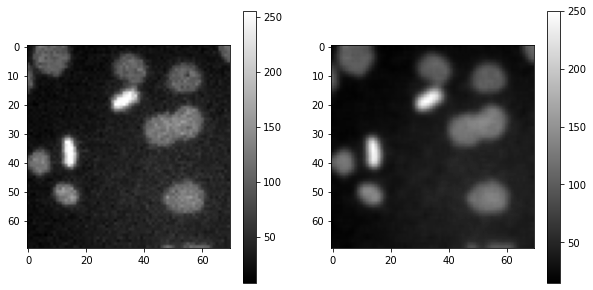

In [140]:
# Let's plot before and after mean filtering:
mean_filtered = ndi.correlate(mitosis_img, mean_kernel)

fig, ax = plt.subplots(1,2, figsize=(10,5)) 

axes_image0 = ax[0].imshow(mitosis_img, cmap='gray') 
plt.colorbar(axes_image0, ax=ax[0]) 

axes_image1 = ax[1].imshow(mean_filtered, cmap='gray')
plt.colorbar(axes_image1, ax=ax[1]) 

In [69]:
# Example 2: prewitt filter
prewitt_kernel = np.array(
    [[1/3, 0, -1/3],
     [1/3, 0, -1/3],
     [1/3, 0, -1/3]])
print(prewitt_kernel)

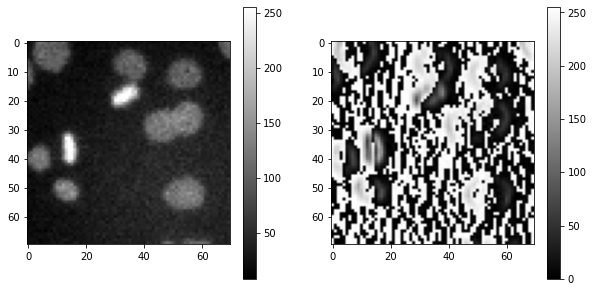

In [70]:
# Let's plot before and after prewitt filtering:
prewitt_filtered = ndi.correlate(mitosis_img, prewitt_kernel)

fig, ax = plt.subplots(1,2, figsize=(10,5)) 

axes_image0 = ax[0].imshow(mitosis_img, cmap='gray') 
plt.colorbar(axes_image0, ax=ax[0]) 

axes_image1 = ax[1].imshow(prewitt_filtered, cmap='gray') 
plt.colorbar(axes_image1, ax=ax[1])

In [71]:
### Try on your on using prewitt filter on this brick image: 
brick_image = data.brick().astype(float)

2. Non-linear filters: they also replace pixel value but in a non linear function:

    - Examples (order statistics): min, max, median 

There are many predefined filters in `ndi.filters`/ `skimage.filters`, like Gaussian blur, or Laplace-filter. 

An important usages of those filters is to __reduce/remove noise, uneveness, and enhance the contrast between objects to detect and the background__. 

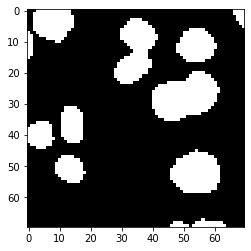

In [141]:
# take a look at thresholding result after we applied mean filter:

mean_binary = mean_filtered > 60
plt.imshow(mean_binary, cmap='gray')

#### __morphological operations__

Morphological operations transform images based on shape. They can be seen as non-linear spatial filters in which the kernel/footprint shape and size have a strong impact in the results. In this context, the kernel is also called structural element (SE).

Strutcutal element
The structural element (SE) is a probe that runs through the image, modifying each pixel depending on how well its shape matches the surroundings. This is best explained with some examples.

Let's create 2 different SE: a square and a disk. Scikit-image has built-in functions to generate those.

In [73]:
# creates a disk of 1 with radius = 3
disk = morphology.disk(3) 
print('disk = \n', disk)
# creates a square with edges = 5
square = morphology.square(5) 
print('square = \n', square)

disk = 
 [[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]
square = 
 [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


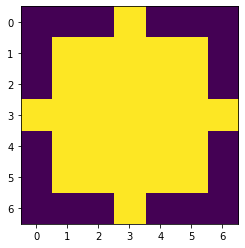

In [74]:
plt.imshow(disk)
# plt.imshow(square)

Erosion and Dilation

The erosion is a spatial minimum filter. This means that, for every pixel, it gets the surronding pixels that underlie the SE shape and returns the minimal value.

In the binary case, this means that, if a pixel has any 0-valued neighbouring pixel around it that lies beneath the SE, it will recevie 0.

Overall, this gives the impression that the white (positive value) structures are getting consumed/eroded.


In [75]:
erode_disk_binary = morphology.binary_erosion(image_binary, disk)
eroded_square_binary = morphology.binary_erosion(image_binary, square)

Text(0.5, 1.0, 'erosion square')

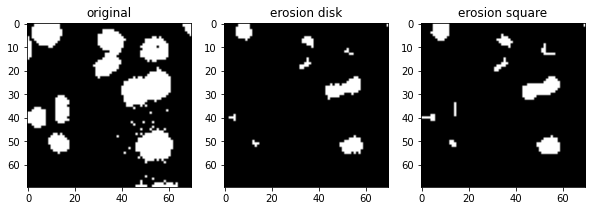

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

ax[0].imshow(image_binary, cmap = 'gray')
ax[0].set_title('original')

ax[1].imshow(erode_disk_binary, cmap = 'gray')
ax[1].set_title('erosion disk')

ax[2].imshow(eroded_square_binary, cmap = 'gray')
ax[2].set_title('erosion square')

In [77]:
### try out dilation yourself using morphology.binary_dilation() with the two SEs.

Openning and Closing

The morphological __opening__ on an image is defined as an erosion followed by a dilation, while __closing__ is a dilation followed by an erosion.

In [78]:
opening_disk_binary = morphology.binary_opening(image_binary, disk)
opening_square_binary = morphology.binary_opening(image_binary, square)

Text(0.5, 1.0, 'opening square')

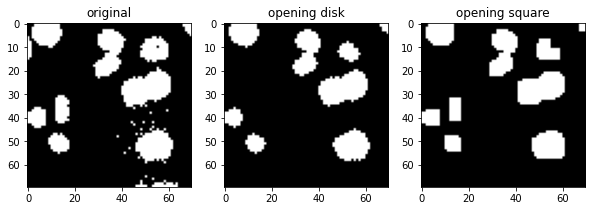

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

ax[0].imshow(image_binary, cmap = 'gray')
ax[0].set_title('original')

ax[1].imshow(opening_disk_binary, cmap = 'gray')
ax[1].set_title('opening disk')

ax[2].imshow(opening_square_binary, cmap = 'gray')
ax[2].set_title('opening square')

In [80]:
### try out closing yourself using morphology.binary_dilation() with the two SEs.

----

### <font color='orange'> Part 3: Feature extraction  </font>  <a id= feature></a>

Filters and morphorlogical operations clean-up the original image, and can make the image more segmentable.

What is image segmentation? Will thrsholding by one number always work?

- __Segmentation__ is defined as assigning a meaningful label to each pixel. 

- __Semantic segmentation__ will further differentiate the labels to meaningful classes: from the instances of those classes we can extract desired features.


Example threshold algo: __Otsu thresholding__

Find threshold so that the summed, weighted varaince of the assignment becomes minimal:

- Variance definition:
\begin{equation}
\operatorname{Var}(I)=\frac{1}{n_{I}} \sum(I-\operatorname{mean}(I))^{2}
\end{equation}

- Objective function to minimize:
\begin{equation}
\operatorname{Var}_{w, \operatorname{sum}}=\frac{n_{A}}{n_{I}} \cdot \operatorname{Var}(A)+\frac{n_{B}}{n_{I}} \cdot \operatorname{Var}(B)
\end{equation}

There are also many others like trangle thresholding, statistical thresholding, where you can find them in `skimage.filters`.

You might sometimes need to refine the mask (segmentation) after thresholding too.

In [82]:
### try out the threshold method skimage.filters.threshold_li() on the smoothed image. (Li's iterative Minimum Cross Entropy method)

But after that, you will need to differentiating different objects, and here connected component analysis (CCA) is used to mark pixel that belong to differnet object with different numbers.

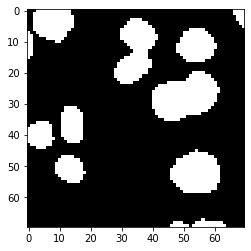

In [83]:
plt.imshow(mean_binary, cmap='gray')

In [84]:
from skimage.measure import label, regionprops, regionprops_table

label_img = label(mean_binary)
print(label_img)

[[0 0 0 ... 2 2 2]
 [0 0 1 ... 2 2 2]
 [0 0 1 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


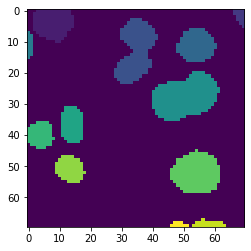

In [85]:
plt.imshow(label_img)

Finally we are in a good position to be able to extract relavant features from the image.

A __feature__ is a countable or measureable property of an image or an object.

Goal of feature extraction is finding a minimal set of features to describe an object well enough to differentiate it from other objects: 


In [86]:
regions = regionprops(label_img)

A very handy function is [`skimage.measure.regionprops()`](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprop#skimage.measure.regionprops), which can measure many properties of labeled image regions that are of common interest, like area or axis lengths. 

In [87]:
properties = ['area', 'convex_area', 'mean_intensity', 'orientation', 'axis_major_length','axis_minor_length']

pd.DataFrame(regionprops_table(label_img, mitosis_img, properties=properties))

,area,convex_area,mean_intensity,orientation,axis_major_length,axis_minor_length
0,114,118,94.315789,1.510549,13.505230,10.976665
1,17,18,96.705882,0.387294,6.446564,3.547836
2,185,223,116.724324,-0.218256,23.504330,11.441279
3,108,114,89.981481,-1.525488,12.363808,11.150568
4,16,16,88.312500,0.000000,9.380832,1.984313
5,246,265,108.121951,-1.254024,23.432760,13.617576
6,75,76,146.493333,0.071073,12.741487,7.481397
7,62,68,102.483871,-0.200897,9.084654,8.738291
8,171,180,102.204678,-1.539651,16.159769,13.532801
9,67,71,106.641791,0.949138,10.174913,8.371777


---

### <font color='orange'> Part 4: Analysis pipeline on a toy example </font>  <a id= example></a>

We want to analyze the variation of cell size in a tissue, which can sometimes be critical to plant organ development.

Again, this is a workflow demo, and we will <font color='purple'> SAVE EVERY FILTERED IMAGE as a NEW IMAGE OBJECT. </font>


In [88]:
# loading an microscopy image:
img_color = imread('plant_cell.tiff')

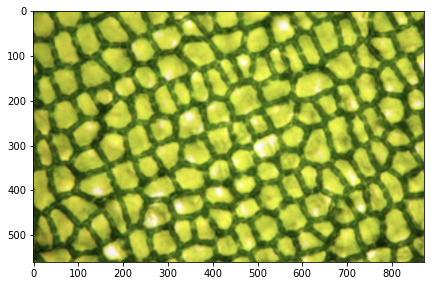

In [89]:
plt.figure(figsize=(7,7))
plt.imshow(img_color)
plt.show()

In [90]:
#  convert to grayscale:
from skimage.color import rgb2gray
img = np.uint8(rgb2gray(img_color) * 255)

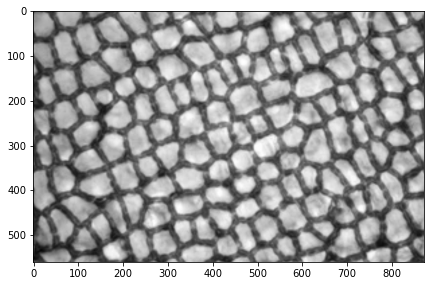

In [91]:
plt.figure(figsize=(7,7))
plt.imshow(img, cmap = 'gray')
plt.show()

In [92]:
sigma = 3 # set the standard deviation for Gaussian kernel
img_smooth = ndi.filters.gaussian_filter(img, sigma)

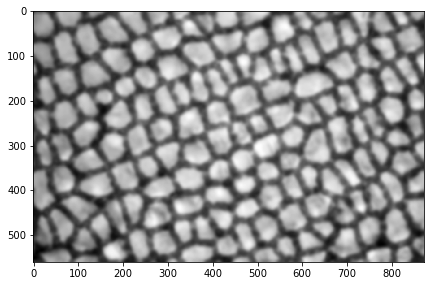

In [93]:
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.show()

In [94]:
# manually detect threshold:
from ipywidgets import interact

@interact(thresh=(10,250,10))
def select_threshold(thresh=100):
    
    # thresholding
    binary = img_smooth > thresh
    
    # visualization
    plt.figure(figsize=(7,7))
    plt.imshow(binary, cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='thresh', max=250, min=10, step=10), Output()), _dom_cl…

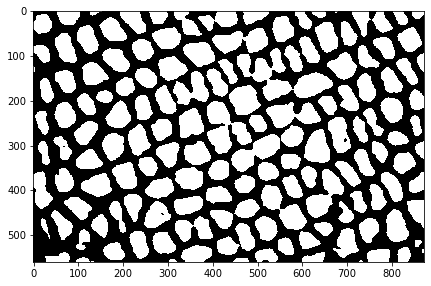

In [95]:
from skimage.filters.thresholding import threshold_otsu

# calculate and apply threshold
thresh = threshold_otsu(img_smooth)
otsu_binary = img_smooth > thresh
    
# visualization
plt.figure(figsize=(7,7))
plt.imshow(otsu_binary, interpolation='none', cmap='gray')
plt.show()

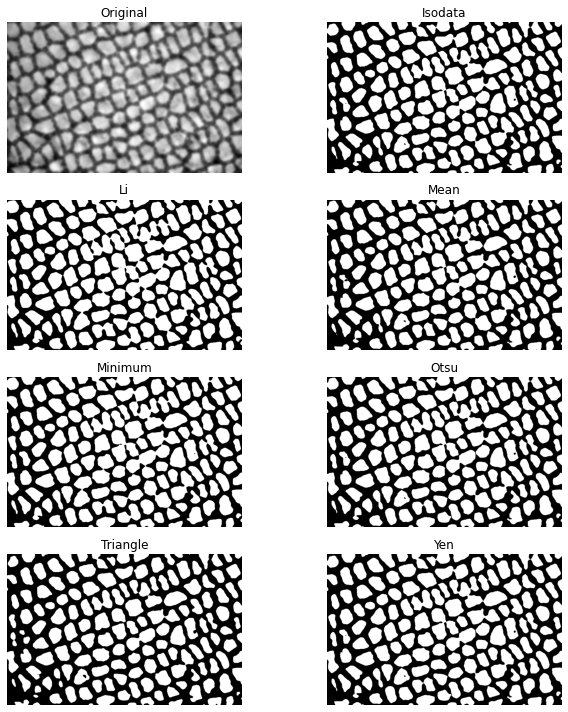

In [96]:
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(img_smooth, figsize=(10,10), verbose=False)

Let's try adaptive thresholding too.

We'll implement two steps of adaptive background subtraction.

1. Use a strong "mean filter" with a circular `SE` to create the background image.

2. Use the background image for thresholding.

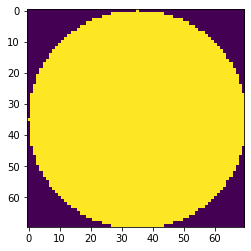

In [97]:
# define an SE filter:
i = 70
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# visualize the result:
plt.imshow(SE, interpolation='none')
plt.show()

In [98]:
from skimage.filters import rank 
# rank returns local mean for the neighborhood defined by the footprint
bg = rank.mean(img_smooth, footprint=SE)

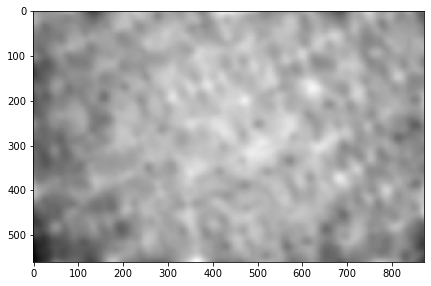

In [99]:
plt.figure(figsize=(7,7))
plt.imshow(bg, interpolation='none', cmap='gray')
plt.show()

In [100]:
# binarize it:
cells = img_smooth > bg

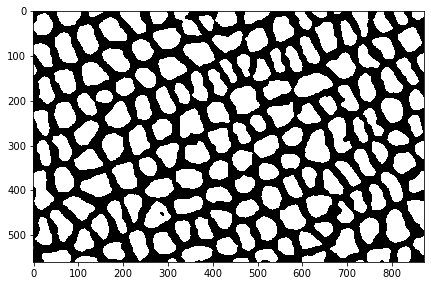

In [101]:
plt.figure(figsize=(7,7))
plt.imshow(cells, interpolation='none', cmap='gray')
plt.show()


In [102]:
# refine segmentation by filling the holes:
cells_final = ndi.binary_fill_holes(cells)  

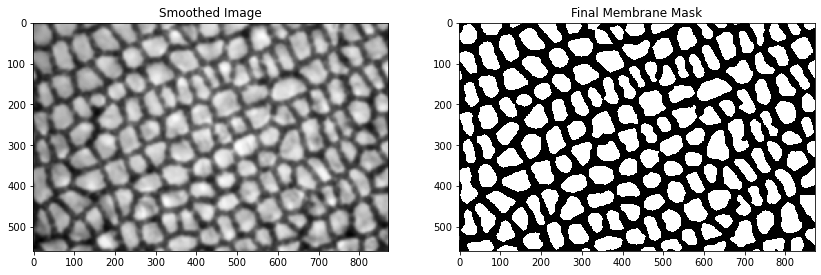

In [103]:
# plot side by side:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(cells_final, interpolation='none', cmap='gray')
ax[0].set_title('Smoothed Image')
ax[1].set_title('Final Membrane Mask')
plt.show()

In [142]:
# CCA:
cell_labels = label(cells_final)

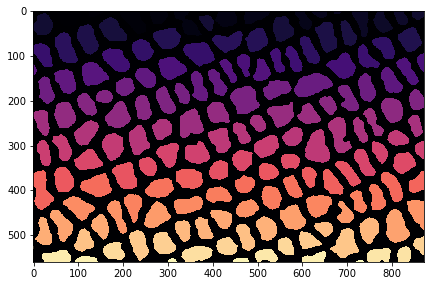

In [143]:
plt.figure(figsize=(7,7))
plt.imshow(cell_labels, interpolation='none', cmap='magma')
plt.show()

Let's find the seeds of the cells using using the distance transform approach; you can try `regionprop()` too. But the segmentation actually created a thicker gap between cells than reality, so the features extracted will have a systematic measurement bias.

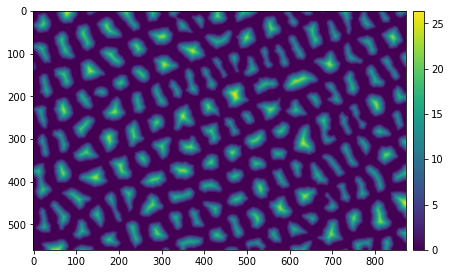

In [147]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

dist_trans = ndi.distance_transform_edt(cells_final)

fig, ax = plt.subplots(figsize = (7,7))
im = ax.imshow(np.arange(100).reshape((10, 10)))

im = ax.imshow(dist_trans)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

plt.colorbar(im, cax=cax)
plt.show()

Smooth the distance transform, so that we only have one local maximum.

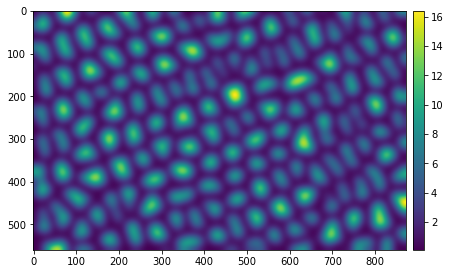

In [148]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

dist_trans_smooth = ndi.filters.gaussian_filter(dist_trans, sigma=10)

dist_trans = ndi.distance_transform_edt(cells_final)

fig, ax = plt.subplots(figsize = (7,7))
im = ax.imshow(np.arange(100).reshape((10, 10)))

im = ax.imshow(dist_trans_smooth)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

plt.colorbar(im, cax=cax)
plt.show()

In [108]:
# retrieve peak coordinates:
from skimage.feature import peak_local_max
seed_coords = peak_local_max(dist_trans_smooth, min_distance=15)

# convert coords to mask that has the same size as the image:
seeds = np.zeros_like(dist_trans_smooth, dtype=bool)
seeds[tuple(seed_coords.T)] = True

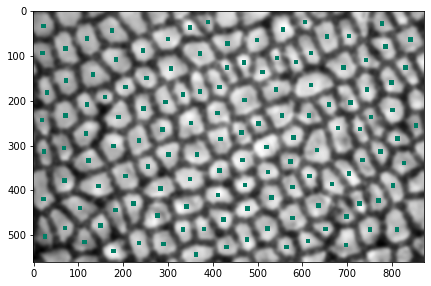

In [109]:
# dilate seeds:
seeds_dil = ndi.filters.maximum_filter(seeds, size=10)

# create plots to visualize seeds:
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, cmap='gray')
plt.imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap= 'summer')
plt.show()

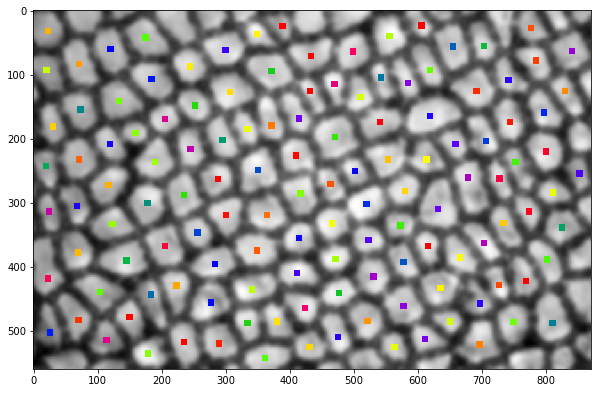

In [110]:
# use connected component labeling to give each cell seed a unique ID number.
seeds_labeled = ndi.label(seeds)[0]

# visualize the final result (the labeled seeds) as an overlay on the raw (or smoothed) image
seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10)  # Expand a bit for visualization
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0), cmap='prism')
plt.show()

Expand seeds by watershed expansion:

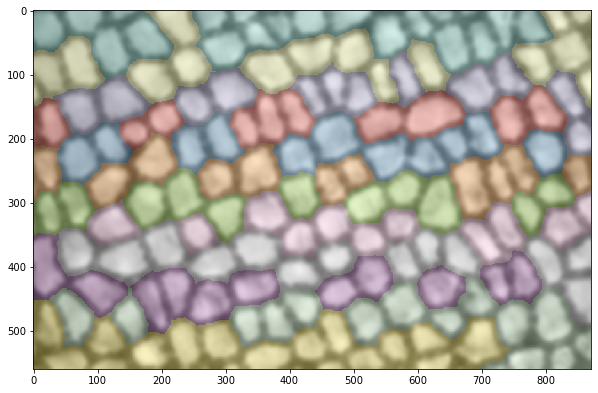

In [111]:
from skimage.segmentation import watershed
# find the watershed lines that are the local minimas:
ws = watershed(~img_smooth, seeds_labeled)

plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='Set3', alpha=0.4)
plt.show()

Iterate through cells and remove those touching the image border:

In [112]:
border_mask = np.zeros(ws.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

clean_ws = np.copy(ws)

for cell_ID in np.unique(ws):

    # mask that only have cells with current ID:
    cell_mask = ws == cell_ID 
    cell_border_overlap = np.logical_and(cell_mask, border_mask)  
    total_overlap_pixels = np.sum(cell_border_overlap)          

    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    if total_overlap_pixels > 0: 
        clean_ws[cell_mask] = 0

In [113]:
# preserve labels:
for new_ID, cell_ID in enumerate(np.unique(clean_ws)[1:]):
    clean_ws[clean_ws==cell_ID] = new_ID+1                

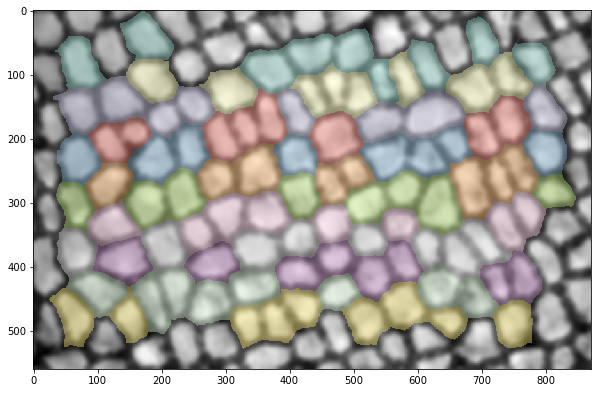

In [114]:
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(clean_ws, mask=clean_ws==0), interpolation='none', cmap='Set3', alpha=0.4)
plt.show()

Identify cell edges:

In [115]:
edges = np.zeros_like(clean_ws)

for cell_ID in np.unique(clean_ws)[1:]:
    # erode the mask by 1 pixel
    cell_mask = clean_ws==cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1) 
    # create the cell edge mask
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    edges[edge_mask] = cell_ID

Finally, feature extraction.

In [117]:
# create a dictionary that contains a key-value pairing for each measurement
results = {"cell_id"      : [],
           "int_mean"     : [],
           "int_mem_mean" : [],
           "cell_area"    : [],
           "cell_edge"    : []}


In [118]:
for cell_id in np.unique(clean_ws)[1:]:

    # Mask the current cell and cell edge
    cell_mask = clean_ws==cell_id
    edge_mask = edges==cell_id
    
    # Get the measurements
    results["cell_id"].append(cell_id)
    results["int_mean"].append(np.mean(img[cell_mask]))
    results["int_mem_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

In [150]:
# print the results to see if they make sense:
for key in results.keys(): 
    print(key + ":", results[key][:5], '\n')

cell_id: [1, 2, 3, 4, 5] 

int_mean: [143.55705492424244, 150.17437345570067, 161.45415959252972, 159.74213836477986, 149.92196803509873] 

int_mem_mean: [80.92207792207792, 94.98421052631579, 95.625, 95.07870370370371, 87.7005076142132] 

cell_area: [4224, 2833, 3534, 3816, 3191] 

cell_edge: [231, 190, 200, 216, 197] 



#### Simple analysis and visualization

plot of cell outline length over cell area:

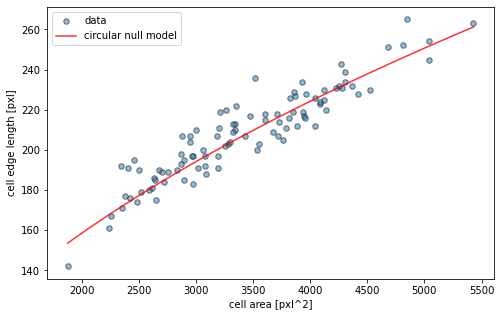

In [155]:
plt.figure(figsize=(8,5))
# scatter area v.s. edge length
plt.scatter(results["cell_area"], results["cell_edge"],
            edgecolor='k', s=30, alpha=0.5)

# calculate the null relationship between area and circumference
cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num=100)
circle_circumference = 2 * np.pi * np.sqrt( cell_area_range / np.pi )
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)

plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")
plt.legend(['data', 'circular null model'], loc=2, fontsize=10)
plt.show()

map cell size on to the image as a heatmap:

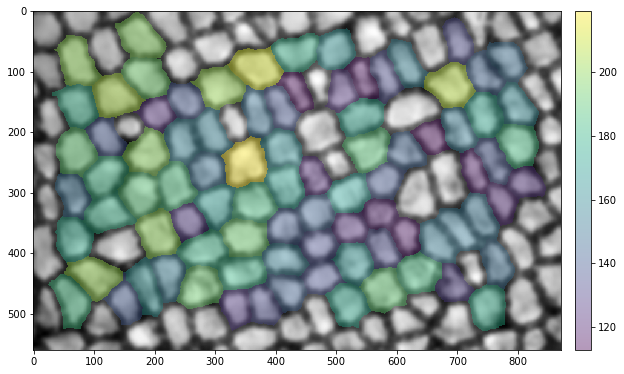

In [120]:
# scale the area back to 8bit intensity scale:
areas_8bit = np.array(results["cell_area"]) / max(results["cell_area"]) * 255

area_map = np.zeros_like(clean_ws, dtype=np.uint8) 

for index, cell_id in enumerate(results["cell_id"]):
    # assign rescalled value:
    area_map[clean_ws==cell_id] = areas_8bit[index]

# exclude the extreme 5% (two sides):
outlier_mask = np.logical_or(area_map > np.percentile(areas_8bit, 95),
                             area_map < np.percentile(areas_8bit, 5))

# the region that we won't color (outliers + image boundary cells)
full_mask = np.logical_or(area_map==0, outlier_mask)

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(img_smooth, cmap='gray')
# heatmap:
coloring = ax.imshow(np.ma.array(area_map, mask=full_mask), cmap='viridis', alpha=0.4)

# colorbar:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)

plt.colorbar(coloring, cax=cax)

plt.show()